# Pairs Trading: Performance of a Relative-Value Arbitrage Rule

Signal: z-score weighted spread between historically correlated asset pairs


### Part 1 - Pairs Formation

- CRSP daily data (Jan 1, 1962 - Dec 31, 2002)

- 12 month formation period

In [1]:
# importing libraries

import silverfund.data_access_layer as dao
from silverfund.enums import Interval
from datetime import date
from dateutil.relativedelta import relativedelta

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading CRSP data

interval = Interval.DAILY
start_date = date(1962, 1, 1)
end_date = date(2015, 12, 31)

crsp = dao.load_crsp(interval=interval, start_date=start_date, end_date=end_date)

# screen out stocks where one or more days had no trade
crsp = crsp.filter((pl.col("vol").is_null()) | (pl.col("vol") == 0))

Loading CRSP Daily: 100%|██████████| 54/54 [00:05<00:00, 10.63it/s]


In [3]:
# construct a normalized cumulative total returns index for each stock over the formation period

crsp = (
    crsp.filter([pl.col("ret").is_not_null()])
    .sort(["permno", "date"])
    .with_columns([(1 + pl.col("ret")).log().alias("logret")])
)

crsp = crsp.sort(["permno", "date"]).with_columns(
    [pl.col("logret").cum_sum().over("permno").exp().alias("cumret_index")]
)

crsp = crsp.with_columns(
    [(pl.col("cumret_index") / pl.col("cumret_index").first().over("permno")).alias("cumret_norm")]
)

In [4]:
# constrain to benchmark permnos

russell = dao.russell_consituents.load_russell_constituents()

russell = (
    russell.select(pl.col("permno"))
    .cast(pl.Int64)
    .unique()
    .filter(pl.col("permno").is_not_null())
    .sort("permno")
)

df = crsp.join(russell, on="permno", how="inner")

In [26]:
# compute squared deviation for two stocks


def match(dataframe, start_date, end_date):
    match = dataframe.select(["date", "permno", "cumret_norm"]).filter(
        [pl.col("date") >= start_date, pl.col("date") <= end_date]
    )
    print(match)

    # restrict to random 100 stocks for testing purposes
    rand = match.select(pl.col("permno")).unique().sample(n=100)
    match = match.join(rand, on="permno", how="inner")

    # pivot in pandas bc polars doesn't handle wide data well
    match_df = (
        match.pivot(index="date", on="permno", values="cumret_norm").fill_null(0).sort(["date"])
    )
    print(match_df)

    # loop over each pair of stocks to calculate the distance
    matches_list = []
    for stock_1 in [col for col in match_df.columns if col != "date"]:
        try:
            stock1 = np.array(match_df[stock_1].to_list())
            min_distance = np.inf
            best_match = None
            for stock_2 in [col for col in match_df.columns if col != "date"]:
                if stock_2 != stock_1:  # Skip self-matching
                    stock2 = np.array(match_df[stock_2].to_list())
                    distance = np.sum((stock1 - stock2) ** 2)
                    if distance < min_distance:
                        min_distance = distance
                        best_match = stock_2
        except Exception as e:
            print(f"Error with in checking matches for {stock_1}.\n{e}")

        matches_list.append([end_date, stock_1, best_match])

    # return match dataframe
    return matches_list

In [27]:
# matching over formation period on a monthly rolling basis

start = date(1997, 1, 1)
end = start + relativedelta(months=12)
pairs_list = []

while end <= date(2015, 1, 1):
    print(end)
    pairs_list.extend(match(crsp, start, end))
    start += relativedelta(months=6)
    end += relativedelta(months=6)

pairs = pl.DataFrame(pairs_list, schema={"date": pl.Date, "permno": pl.Int64, "match": pl.Int64})

1998-01-01
shape: (164_172, 3)
┌────────────┬────────┬─────────────┐
│ date       ┆ permno ┆ cumret_norm │
│ ---        ┆ ---    ┆ ---         │
│ date       ┆ i64    ┆ f64         │
╞════════════╪════════╪═════════════╡
│ 1997-01-13 ┆ 10001  ┆ 0.571391    │
│ 1997-01-24 ┆ 10001  ┆ 0.588972    │
│ 1997-02-26 ┆ 10001  ┆ 0.5719      │
│ 1997-03-10 ┆ 10001  ┆ 0.589497    │
│ 1997-03-17 ┆ 10001  ┆ 0.57241     │
│ …          ┆ …      ┆ …           │
│ 1997-11-11 ┆ 93316  ┆ 2434.14178  │
│ 1997-11-12 ┆ 93316  ┆ 2402.322679 │
│ 1997-11-24 ┆ 93316  ┆ 2434.352847 │
│ 1997-11-28 ┆ 93316  ┆ 2483.039904 │
│ 1997-12-11 ┆ 93316  ┆ 2517.055068 │
└────────────┴────────┴─────────────┘
shape: (253, 101)
┌────────────┬───────┬───────┬───────┬───┬──────────┬───────┬─────────┬──────────┐
│ date       ┆ 10244 ┆ 11066 ┆ 11138 ┆ … ┆ 84837    ┆ 85026 ┆ 85202   ┆ 85375    │
│ ---        ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---      ┆ ---   ┆ ---     ┆ ---      │
│ date       ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64      ┆ f6

/tmp/ipykernel_528891/287109786.py:13: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairs = pl.DataFrame(


In [30]:
pairs

date,permno,match
date,i64,i64
1998-01-01,10244,85026
1998-01-01,11066,79656
1998-01-01,11138,83846
1998-01-01,11971,77187
1998-01-01,13507,84628
…,…,…
2015-01-01,92921,11264
2015-01-01,92979,91763
2015-01-01,93208,14188


### Signal Calculation

- rebalance monthly

In [31]:
# merging on returns data for both permnos in pairs

returns = df.join(pairs, on=["date", "permno"], how="inner")

match_returns = returns.select(["date", "permno", "cumret_norm", "ret"]).rename(
    {"permno": "match", "cumret_norm": "match_cumret_norm", "ret": "match_ret"}
)

returns = returns.join(match_returns, on=["date", "match"], how="inner")

In [32]:
returns

permno,permco,date,ncusip,ticker,shrcd,exchcd,siccd,prc,ret,retx,vol,shrout,cfacshr,logret,cumret_index,cumret_norm,match,match_cumret_norm,match_ret
i64,i64,date,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64
10089,8033,2003-07-01,"""02078110""","""ATGI""",11,3,3644,-1.755,0.002857,0.002857,0.0,7110.0,1.0,0.002853,17.183667,17.183667,46068,1.615646,-0.020927
87119,7484,2003-07-01,"""22819010""","""CRAN""",11,3,2890,-2.435,0.014583,0.014583,0.0,1865.0,1.0,0.014478,6.76933,6.704863,46068,1.615646,-0.020927
80336,12951,2005-07-01,"""51504L10""","""LARK""",11,3,6030,-25.0,-0.003988,-0.003988,0.0,2120.0,2.526949,-0.003996,19.764173,19.513984,47036,7.976501,-0.01049
47036,20746,2005-07-01,"""34482010""","""FSM""",11,2,5411,-35.375,-0.01049,-0.01049,0.0,988.0,1.0,-0.010545,8.008152,7.976501,55634,7.85683,0.0
63992,2117,1998-07-01,"""42341810""","""HHH""",11,2,2821,-0.875,0.0,0.0,0.0,3744.0,1.0,0.0,2429.479779,2429.479779,65700,1452.092151,-0.027778
12253,10045,2003-07-01,"""35803U10""","""FRSH""",11,3,5141,-14.045,0.0,0.0,0.0,5038.0,1.0,0.0,38.711909,38.711909,75284,4.512968,-0.005405


In [33]:
# calculating gap between pair
returns = returns.sort(["permno", "date"]).with_columns(
    (pl.col("cumret_norm") - pl.col("match_cumret_norm")).alias(
        "match_gap"
    ),  # this needs to just be the gap at end of formation period
    pl.col("ret").shift(1).alias("lagret"),
)

# sorting stocks into decile bins by size of gap
returns = returns.with_columns(
    (pl.col("match_gap").sign() * pl.col("lagret")).alias("obs_ret"),
    pl.col("match_gap")
    .qcut(10, labels=[f"{i}" for i in range(10)], allow_duplicates=True)
    .alias("gap_decile"),
)

# generating cumulative returns within each decile
returns = (
    returns.group_by(["date", "gap_decile"])
    .agg(pl.col("obs_ret").sum().alias("obs_ret"))
    .sort(["gap_decile", "date"])
)
returns = returns.with_columns(
    pl.col("obs_ret").cum_sum().over("gap_decile").alias("obs_cumret")
).filter(pl.col("gap_decile").is_not_null())

In [34]:
returns

date,gap_decile,obs_ret,obs_cumret
date,cat,f64,f64
2005-07-01,"""0""",0.0,0.0
2003-07-01,"""1""",-0.003988,-0.003988
2005-07-01,"""3""",0.0,0.0
2003-07-01,"""5""",0.0,0.0
2003-07-01,"""7""",0.002857,0.002857
1998-07-01,"""9""",-0.01049,-0.01049


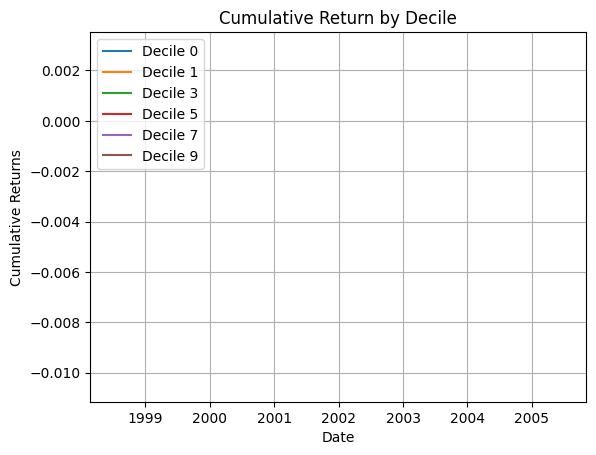

In [35]:
# plotting data

pd_returns = returns.to_pandas()
pd_returns.sort_values(["gap_decile", "date"])

for dec in pd_returns["gap_decile"].unique():
    subset = pd_returns[pd_returns["gap_decile"] == dec]
    plt.plot(subset["date"], subset["obs_cumret"], label=f"Decile {dec}")

plt.legend()
plt.title("Cumulative Return by Decile")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()

In [37]:
# adding spread port

pivoted_returns = returns.pivot(index="date", on="gap_decile", values="obs_cumret")

result = pivoted_returns.sort("date").with_columns([(pl.col("9") - pl.col("0")).alias("spread")])
result

date,0,1,3,5,7,9,spread
date,f64,f64,f64,f64,f64,f64,f64
1998-07-01,null,null,null,null,null,-0.01049,null
2003-07-01,null,-0.003988,null,0.0,0.002857,null,null
2005-07-01,0.0,null,0.0,null,null,null,null


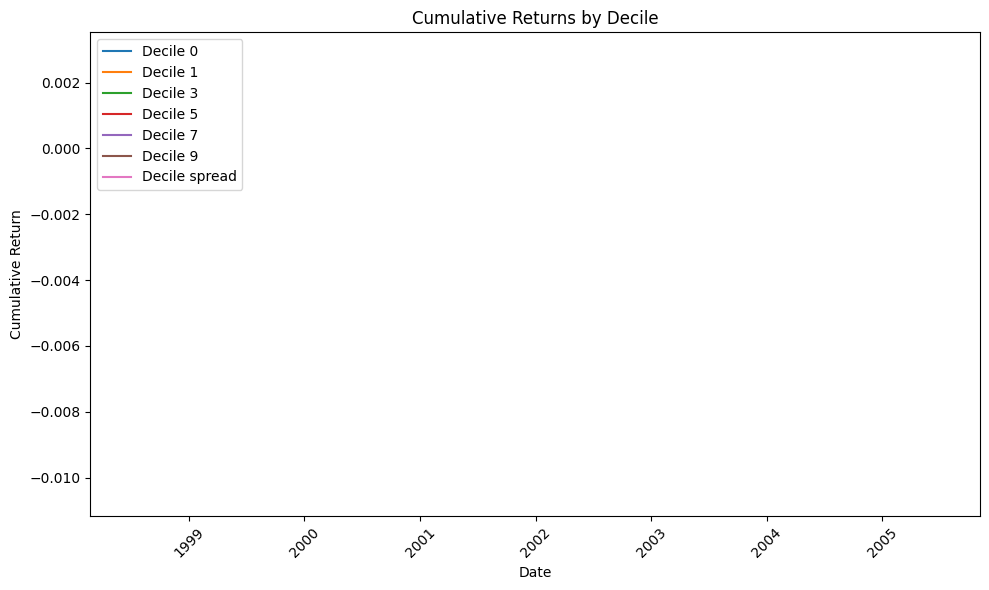

In [38]:
# plotting spread

pd_result = result.to_pandas()
pd_result.sort_values("date")

plt.figure(figsize=(10, 6))
for column in pd_result.drop(columns=["date"]).columns:
    plt.plot(pd_result["date"], pd_result[column], label=f"Decile {column}")

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns by Decile")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### To Do:

- z score gap for signal formation
- figure out how to run on the entire universe of stocks not just random sample
- check and see how much pairs change from month to month
- sic code binning for pairs
- volatility adjust

### Questions:

- how to run this through the optimizer